# Downloading data and initial exlporation

## Importing libraries and datasets

In [1]:
# Libraries
! pip install openai
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import openai
#import tiktoken
import time
from tqdm import tqdm

In [2]:
# Load the datasets
interactions = pd.read_csv('https://raw.githubusercontent.com/olivialaven/MGT502_project/refs/heads/main/interactions_train.csv')
items = pd.read_csv("https://raw.githubusercontent.com/olivialaven/MGT502_project/refs/heads/main/items.csv")

# Display the first rows of each dataset
display(interactions.head())
display(items.head())

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [3]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       15291 non-null  object
 1   Author      12638 non-null  object
 2   ISBN Valid  14568 non-null  object
 3   Publisher   15266 non-null  object
 4   Subjects    13068 non-null  object
 5   i           15291 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 716.9+ KB


In [4]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87047 entries, 0 to 87046
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   u       87047 non-null  int64  
 1   i       87047 non-null  int64  
 2   t       87047 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


In [5]:
n_users = interactions.u.nunique()
n_items = items.i.nunique() # CHECK
print(f'Number of users = {n_users}, \nNumber of books (in total, incl. unread books) = {n_items} \nNumber of interactions = {len(interactions)}')


Number of users = 7838, 
Number of books (in total, incl. unread books) = 15291 
Number of interactions = 87047


## Checking for duplicates

In [6]:
# Checking duplicates in the interactions and items datasets
interaction_duplicates = interactions.duplicated().sum()
items_duplicates = items.duplicated().sum()
print(f'Interaction data duplicates = {interaction_duplicates}, Item data duplicates = {items_duplicates}')

Interaction data duplicates = 2, Item data duplicates = 0


In [7]:
# Showing the duplicated rows
duplicate_rows = interactions[interactions.duplicated(keep=False)]  # keep=False to show all duplicates
print(f"Duplicate rows in interaction data:\n{duplicate_rows}")

Duplicate rows in interaction data:
          u      i             t
4156   7210  12290  1.718023e+09
6103   7210  12290  1.718023e+09
34656  1323  10037  1.700055e+09
44025  1323  10037  1.700055e+09


In [8]:
# Drop the duplicate
interactions.drop_duplicates(keep='first', inplace=True)

In [9]:
# Sanity check, making sure duplicates are dropped
interaction_duplicates = interactions.duplicated().sum()
items_duplicates = items.duplicated().sum()
print(f'Interaction data duplicates = {interaction_duplicates}, Item data duplicates = {items_duplicates}')

Interaction data duplicates = 0, Item data duplicates = 0


## Exploring unique and missing values

In [10]:
# Getting the unique values for each column
# -----------------------------------------

# For interactions DataFrame
unique_counts_interactions = {column: interactions[column].nunique() for column in interactions.columns}
unique_counts_interactions_df = pd.DataFrame(unique_counts_interactions, index=['Unique Values']).T
print("Unique Value Counts for interactions DataFrame:")
display(unique_counts_interactions_df)

# For items DataFrame
unique_counts_items = {column: items[column].nunique() for column in items.columns}
unique_counts_items_df = pd.DataFrame(unique_counts_items, index=['Unique Values']).T
print("\nUnique Value Counts for items DataFrame:")
display(unique_counts_items_df)

Unique Value Counts for interactions DataFrame:


,Unique Values
u,7838
i,15109
t,86768



Unique Value Counts for items DataFrame:


,Unique Values
Title,14576
Author,9357
ISBN Valid,14490
Publisher,4337
Subjects,11521
i,15291


In [11]:
# Getting the missing values for each column
# -----------------------------------------

# For interactions DataFrame
missing_interactions = interactions.isnull().sum()
missing_interactions_df = pd.DataFrame(missing_interactions, columns=['Missing Values']).T

# For items DataFrame
missing_items = items.isnull().sum()
missing_items_df = pd.DataFrame(missing_items, columns=['Missing Values']).T

# Display the DataFrames
print("Missing Values in interactions DataFrame:")
display(missing_interactions_df)

print("\nMissing Values in items DataFrame:")
display(missing_items_df)

Missing Values in interactions DataFrame:


,u,i,t
Missing Values,0,0,0



Missing Values in items DataFrame:


,Title,Author,ISBN Valid,Publisher,Subjects,i
Missing Values,0,2653,723,25,2223,0


### Investigating entries where all columns (except Title) is NaN

In [12]:
# Getting the rows with all NaN
items[items['Author'].isnull() & items['Subjects'].isnull() & items['ISBN Valid'].isnull() & items['Publisher'].isnull()]

,Title,Author,ISBN Valid,Publisher,Subjects,i
1345,YYYY Prêt interbibliothèques BPUL,NaN,NaN,NaN,NaN,1345
9460,"4bis-113: Périodique (prêt 28 jours), numéro n...",NaN,NaN,NaN,NaN,9460
11744,Lectures Courantes Extraites des Écrivains Fra...,NaN,NaN,NaN,NaN,11744
14378,Clé USB 8Go,NaN,NaN,NaN,NaN,14378


In [13]:
# Create a list of item IDs to check (from results above)
item_ids_to_check = [1345, 9460, 11744, 14378]

# Filter the interactions DataFrame to get rows with the specified item IDs
filtered_interactions = interactions[interactions['i'].isin(item_ids_to_check)]

# Display the filtered DataFrame
display(filtered_interactions)

,u,i,t
775,1993,11744,1.706205e+09
8523,1187,9460,1.707217e+09
19214,76,1345,1.685960e+09
20149,1187,9460,1.707217e+09
23493,1623,1345,1.693214e+09
24474,1565,1345,1.693581e+09
25329,1187,9460,1.688753e+09
29207,1187,9460,1.688753e+09
29641,1993,11744,1.706205e+09
29670,1993,11744,1.694622e+09


In [14]:
filtered_interactions.shape

(32, 3)

This means that out of the 87047 interactions, there are 32 instances where a user has interacted with an item we have no data on. This is something we keep in mind going forward.

# Using API calls to enhance metadata

## Google Books API

### Loading data and merging with "items"

In [15]:
# Loading data from GitHub
api_data_tf_idf = pd.read_csv("https://raw.githubusercontent.com/olivialaven/MGT502_project/refs/heads/main/book_records.csv")
api_data_tf_idf

,book_id,title,authors,description,mainCategory
0,0,Classification décimale universelle,UDC Consortium (The Hague),NaN,NaN
1,1,Les interactions dans l'enseignement des langues,Francine Cicurel,C'est dans l'interaction en classe que s'actua...,Interaction analysis in education
2,2,Histoire de vie et recherche biographique,"Aneta Slowik, Hervé Breton, Gaston Pineau",Depuis la parution en 1918 de l'ouvrage fondat...,Narrative inquiry (Research method)
3,3,Ce livre devrait me permettre de résoudre le c...,Sylvain Mazas,NaN,NaN
4,4,Le grand monde,Pierre Lemaitre,"Trois histoires d'amour, un lanceur d'alerte, ...",French literature
...,...,...,...,...,...
15286,15286,Le vagabond de Tokyo,Takashi Fukutani,NaN,NaN
15287,15287,God of high school,Yong-Je Park,"Jin Mori, 17 ans, est invité à un tournoi d'ar...",NaN
15288,15288,Blue Lock Tome 7,NaN,NaN,NaN
15289,15289,Red Eyes Sword - Zero !,NaN,Alors qu'elle enquête sur le tombeau d'un roi ...,NaN


In [16]:
# Rename first column to "i" for merging with original items df
api_data_tf_idf.rename(columns={api_data_tf_idf.columns[0]: 'i'}, inplace=True)

# Merge
merged_items = pd.merge(items, api_data_tf_idf, how="left", left_on="i", right_on="i")

### Cleaning the merged DataFrame

In [17]:
# Replace the Author and Title in the main author/title columns, if it is missing, but exists in the info from Google Books API calls
merged_items['Title'].fillna(merged_items['title'], inplace=True)
merged_items['Author'].fillna(merged_items['authors'], inplace=True)

<ipython-input-17-e745e5ea1d41>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_items['Title'].fillna(merged_items['title'], inplace=True)
<ipython-input-17-e745e5ea1d41>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

In [18]:
# Drop the columns from Google Books API calls
merged_items = merged_items.drop(columns=['title', 'authors'])

## ISBNdb

### Loading the data and merging with "merged_items"

In [19]:
# Loading data from GitHub
api_data_ISBNdb = pd.read_csv("https://raw.githubusercontent.com/olivialaven/MGT502_project/refs/heads/main/ISBNdb_api_call.csv")
api_data_ISBNdb

,Unnamed: 0,Title,Author,ISBN Valid,Publisher,Subjects,i,combined_content,first_isbn,publisher,...,authors,title,isbn13,msrp,binding,isbn,isbn10,edition,related,dewey_decimal
0,0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,Classification décimale universelle : édition ...,9.782871e+12,CEFAL,...,['unknown author'],Classification décimale universelle : Edition ...,9.782871e+12,0.0,Paperback,2871303339,2871303339,NaN,NaN,NaN
1,1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,Les interactions dans l'enseignement des langu...,9.782278e+12,DIDIER,...,['Francine Cicurel'],Les interactions dans l'enseignement des langu...,9.782278e+12,0.0,Paperback,2278058320,2278058320,NaN,{'ePub': '227807153X'},NaN
2,2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,Histoire de vie et recherche biographique : pe...,2.343190e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,Ce livre devrait me permettre de résoudre le c...,9.782365e+12,VRAOUM,...,['Sylvain Sylvain mazas'],ce livre devrait me permettre de resoudre le c...,9.782365e+12,0.0,Paperback,236535002X,236535002X,NaN,NaN,NaN
4,4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,"Les années glorieuses : roman / Lemaitre, Pier...",9.782702e+12,CALMANN-LEVY,...,['Pierre Lemaitre'],Le Grand Monde,9.782702e+12,0.0,Paperback,2702180817,2702180817,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15313,15313,Le vagabond de Tokyo /,"Fukutani, Takashi, 1952-2000",9782353480111; 235348011X; 9782353480241; 2353...,Le Lézard noir,Mangas,15286,"Le vagabond de Tokyo / Fukutani, Takashi, 1952...",9.782353e+12,LEZARD NOIR,...,['Takashi FUKUTANI'],Le vagabond de Tokyo 1 - residence dokudami,9.782353e+12,0.0,Paperback,235348011X,235348011X,Hors collection,NaN,NaN
15314,15314,God of high school : le match contre les dieux /,"Park, Yong-Je",9782382880203; 2382880201; 9782382880210; 2382...,Kbooks,NaN,15287,God of high school : le match contre les dieux...,9.782383e+12,KBOOKS,...,['Yong-Je Park'],God of high school T01,9.782383e+12,0.0,Paperback,2382880201,2382880201,NaN,NaN,NaN
15315,15315,Blue Lock /,"Kaneshiro, Muneyuki",9782811650254; 2811650253; 9782811661274; 2811...,Pika,Compétitions; Football; Entraînement (sports);...,15288,"Blue Lock / Kaneshiro, Muneyuki Pika Compétiti...",9.782812e+12,PIKA,...,[],Blue Lock T01,9.782812e+12,0.0,Pocket Book,2811650253,2811650253,NaN,NaN,NaN
15316,15316,Red eyes sword : akame ga kill ! Zero /,Takahiro,9782368522134; 2368522131; 9782368522141; 2368...,Kurokawa,Bandes dessinées; Mangas,15289,Red eyes sword : akame ga kill ! Zero / Takahi...,9.782369e+12,KUROKAWA,...,"['Takahiro', 'Kei Toru']",Red Eyes Sword Zero - tome 1 (1),9.782369e+12,0.0,Paperback,2368522131,2368522131,NaN,NaN,NaN


In [20]:
# Checking what columns add too many rows (should not be more than 15291)
api_data_ISBNdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15318 entries, 0 to 15317
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15318 non-null  int64  
 1   Title                  15318 non-null  object 
 2   Author                 12662 non-null  object 
 3   ISBN Valid             14595 non-null  object 
 4   Publisher              15293 non-null  object 
 5   Subjects               13088 non-null  object 
 6   i                      15318 non-null  int64  
 7   combined_content       15318 non-null  object 
 8   first_isbn             14589 non-null  float64
 9   publisher              11095 non-null  object 
 10  synopsis               7519 non-null   object 
 11  language               11309 non-null  object 
 12  image                  11321 non-null  object 
 13  image_original         11321 non-null  object 
 14  title_long             11321 non-null  object 
 15  di

In [21]:
# Drop rows with duplicates (same item)
def choose_best_row(group):
    return group.loc[group.notnull().sum(axis=1).idxmax()]

api_data_ISBNdb_deduped = api_data_ISBNdb.groupby("i", as_index=False).apply(choose_best_row).reset_index(drop=True)

# Checking that we do not have more than 15291 rows
print(f"✅ Deduplicated API data: {api_data_ISBNdb_deduped.shape}")

✅ Deduplicated API data: (15291, 30)


<ipython-input-21-1698d8d07385>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  api_data_ISBNdb_deduped = api_data_ISBNdb.groupby("i", as_index=False).apply(choose_best_row).reset_index(drop=True)


In [22]:
# Merging with merged_items
merged_items = pd.merge(merged_items, api_data_ISBNdb_deduped, how="left", on="i")

# Sanity check
print(f"✅ Merged shape: {merged_items.shape}")

✅ Merged shape: (15291, 37)


### Cleaning the resulting merged DataFrame

In [23]:
merged_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title_x                15291 non-null  object 
 1   Author_x               13274 non-null  object 
 2   ISBN Valid_x           14568 non-null  object 
 3   Publisher_x            15266 non-null  object 
 4   Subjects_x             13068 non-null  object 
 5   i                      15291 non-null  int64  
 6   description            2603 non-null   object 
 7   mainCategory           1734 non-null   object 
 8   Unnamed: 0             15291 non-null  int64  
 9   Title_y                15291 non-null  object 
 10  Author_y               12638 non-null  object 
 11  ISBN Valid_y           14568 non-null  object 
 12  Publisher_y            15266 non-null  object 
 13  Subjects_y             13068 non-null  object 
 14  combined_content       15291 non-null  object 
 15  fi

In [24]:
# Drop unnecessary columns (old, duplicates of what we already have)
merged_items = merged_items.drop(columns=['Title_y', 'Author_y','ISBN Valid_y','Publisher_y','Subjects_y','combined_content'])

In [25]:
# Renaming main columns for easier readability
merged_items = merged_items.rename(columns={
    'Title_x': 'Title',
    'Author_x': 'Author',
    'ISBN Valid_x': 'ISBN Valid',
    'Publisher_x': 'Publisher',
    'Subjects_x': 'Subjects'
})

In [26]:
# Drop unnecessary column (another column for the IDs)
merged_items = merged_items.drop(columns=['Unnamed: 0'])

In [27]:
# Sanity check
merged_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  15291 non-null  object 
 1   Author                 13274 non-null  object 
 2   ISBN Valid             14568 non-null  object 
 3   Publisher              15266 non-null  object 
 4   Subjects               13068 non-null  object 
 5   i                      15291 non-null  int64  
 6   description            2603 non-null   object 
 7   mainCategory           1734 non-null   object 
 8   first_isbn             14562 non-null  float64
 9   publisher              11068 non-null  object 
 10  synopsis               7494 non-null   object 
 11  language               11282 non-null  object 
 12  image                  11294 non-null  object 
 13  image_original         11294 non-null  object 
 14  title_long             11294 non-null  object 
 15  di

In [28]:
# Adding new information from the API calls
merged_items["Author"] = merged_items["Author"].fillna(merged_items["authors"])
merged_items["Title"] = merged_items["Title"].fillna(merged_items["title"])
merged_items["subjects"] = merged_items["subjects"].replace("['Subjects']", np.nan)

In [29]:
# Drop duplicate columns (no need for them anymore)
columns_to_drop = ['authors', 'title', 'first_isbn']
merged_items = merged_items.drop(columns=columns_to_drop)

## Final merged DataFrame

In [30]:
# Sanity check
merged_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  15291 non-null  object 
 1   Author                 14502 non-null  object 
 2   ISBN Valid             14568 non-null  object 
 3   Publisher              15266 non-null  object 
 4   Subjects               13068 non-null  object 
 5   i                      15291 non-null  int64  
 6   description            2603 non-null   object 
 7   mainCategory           1734 non-null   object 
 8   publisher              11068 non-null  object 
 9   synopsis               7494 non-null   object 
 10  language               11282 non-null  object 
 11  image                  11294 non-null  object 
 12  image_original         11294 non-null  object 
 13  title_long             11294 non-null  object 
 14  dimensions             10993 non-null  object 
 15  di

# Visual explorations

## Most frequent authors, publisher, subjects, and main category

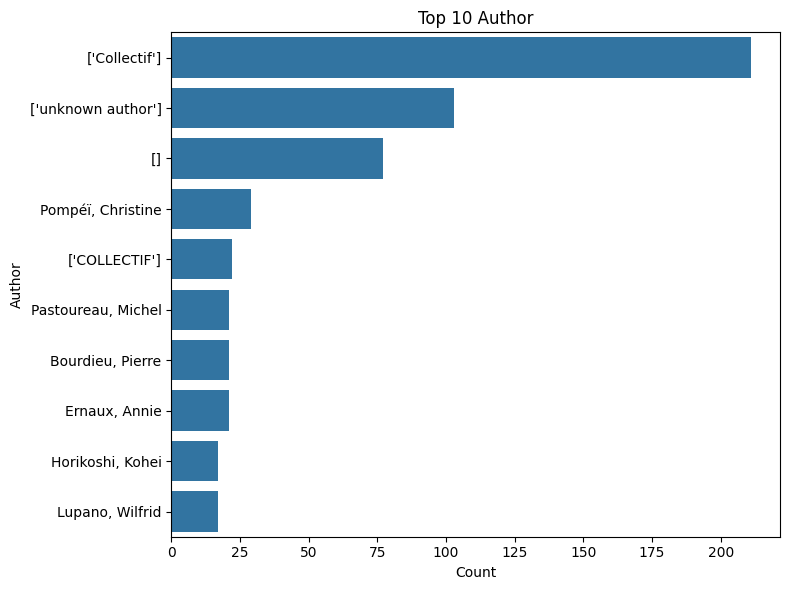

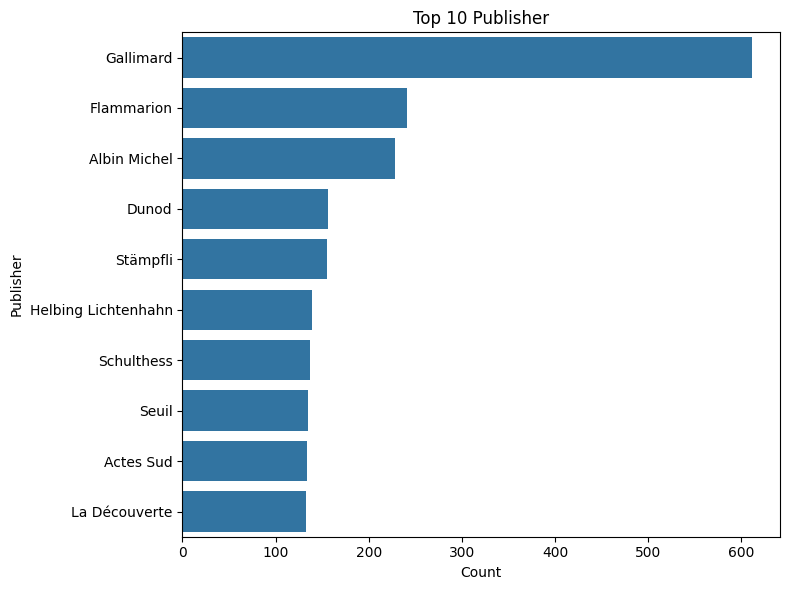

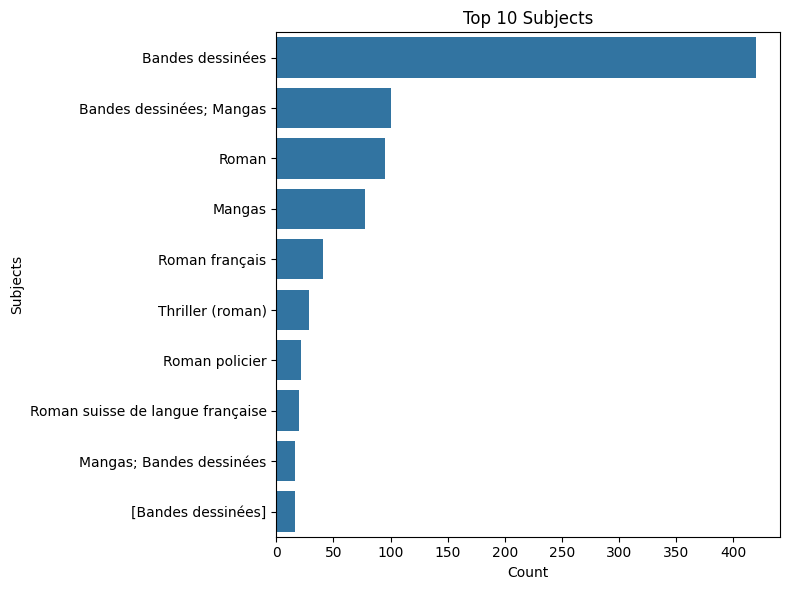

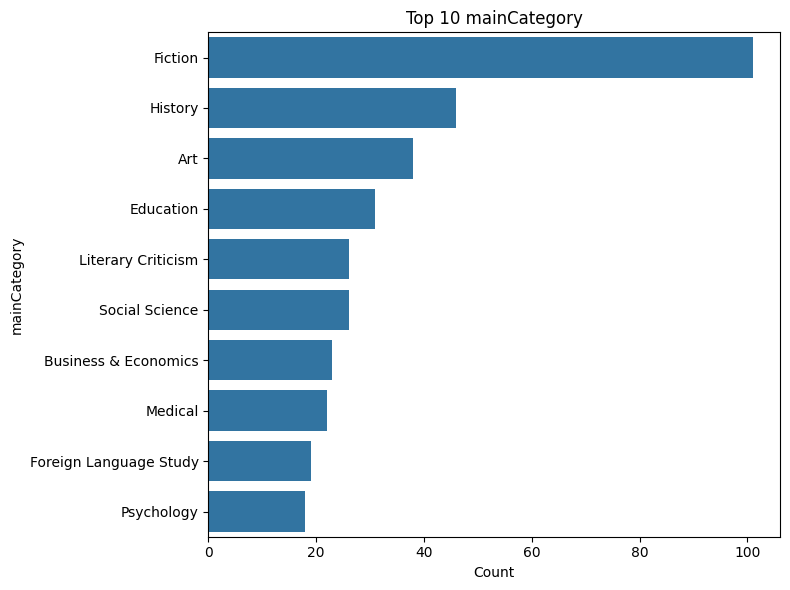

In [31]:
# List of columns to visualize the top 10 for
columns_to_visualize = ['Author', 'Publisher', 'Subjects','mainCategory']

for col in columns_to_visualize:
    if col in merged_items.columns:
        # Get the value counts for the column
        top_values = merged_items[col].value_counts().head(10)

        # Create a figure and axes for the plot
        plt.figure(figsize=(8, 6))

        # Create a bar plot
        sns.barplot(x=top_values.values, y=top_values.index)

        plt.title(f'Top 10 {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in merged_items.")

### Fixing the Author column (replacing faulty names with NaN)

In [32]:
# Removing the [] symbols on all entries
# ----------------------------------

# Iterate through all columns in the DataFrame
for col in merged_items.columns:
    # Ensure the column is of string type to safely apply replace
    merged_items[col] = merged_items[col].astype(str).str.replace('[', '', regex=False).str.replace(']', '', regex=False)

# Display the first few rows to verify
merged_items.head()

,Title,Author,ISBN Valid,Publisher,Subjects,i,description,mainCategory,publisher,synopsis,...,date_published,subjects,isbn13,msrp,binding,isbn,isbn10,edition,related,dewey_decimal
0,Classification décimale universelle : édition ...,UDC Consortium (The Hague),9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,nan,nan,CEFAL,nan,...,2012-03-05,nan,9782871303336.0,0.0,Paperback,2871303339,2871303339,nan,nan,nan
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,C'est dans l'interaction en classe que s'actua...,Interaction analysis in education,DIDIER,Agir professoral et pratiques de classe.<br/>U...,...,2011-11-09,"'Education & Teaching', 'Schools & Teaching'",9782278058327.0,0.0,Paperback,2278058320,2278058320,nan,{'ePub': '227807153X'},nan
2,Histoire de vie et recherche biographique : pe...,"Aneta Slowik, Hervé Breton, Gaston Pineau",2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,Depuis la parution en 1918 de l'ouvrage fondat...,Narrative inquiry (Research method),nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,nan,nan,VRAOUM,Product Description<br/><br/><br/>Sylvain Maza...,...,2012-06-07,nan,9782365350020.0,0.0,Paperback,236535002X,236535002X,nan,nan,nan
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,"Trois histoires d'amour, un lanceur d'alerte, ...",French literature,CALMANN-LEVY,"La famille PelletierTrois histoires d’amour, u...",...,2022-01-25,"'Literature & Fiction', 'Genre Fiction', 'Lite...",9782702180815.0,0.0,Paperback,2702180817,2702180817,nan,nan,nan


In [33]:
# Replacing invalid entries in the Author column with NaN
# ----------------------------------------------------------

# List of string values to replace with NaN
author_values_to_replace_with_nan = ["'Collectif'", "'unknown author'", "", "'COLLECTIF'",'nan']

# Replace the specified string values with a temporary placeholder first
# Using a very unlikely string as a placeholder
temp_placeholder = "__TEMP_NAN_PLACEHOLDER__"
merged_items['Author'] = merged_items['Author'].astype(str).replace(author_values_to_replace_with_nan, temp_placeholder, regex=False)

# Now replace the temporary placeholder with numpy's NaN
merged_items['Author'] = merged_items['Author'].replace(temp_placeholder, np.nan, regex=False)

# Display the unique values in the 'Author' column to check (optional)
print(merged_items['Author'].value_counts(dropna=False).head())

Author
NaN                   1202
Pompéï, Christine       29
Pastoureau, Michel      21
Bourdieu, Pierre        21
Ernaux, Annie           21
Name: count, dtype: int64


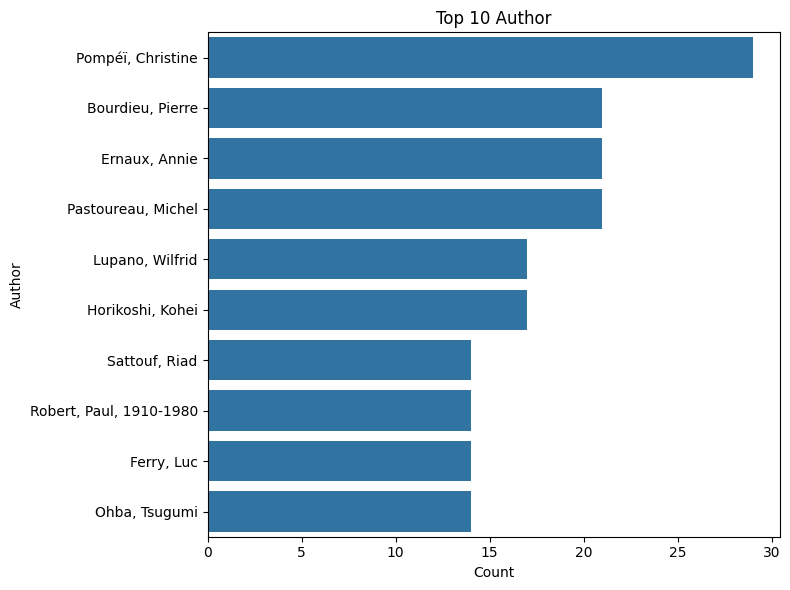

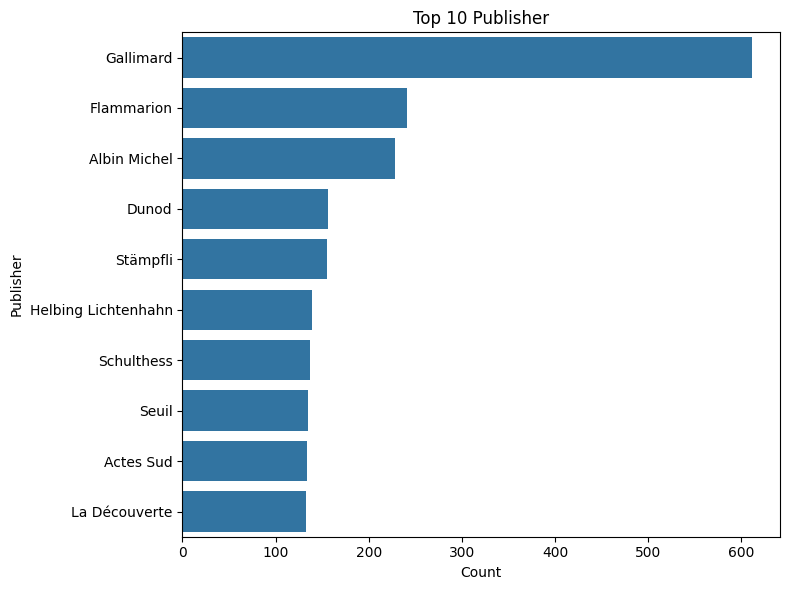

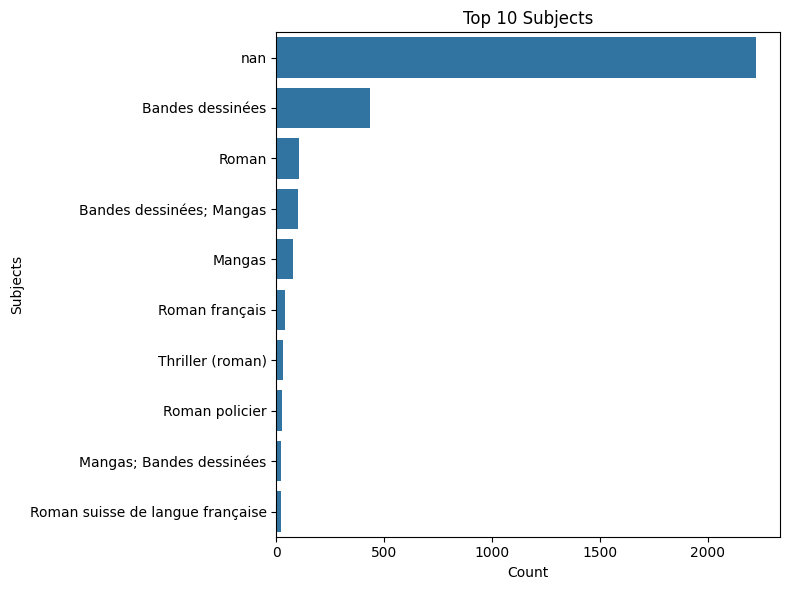

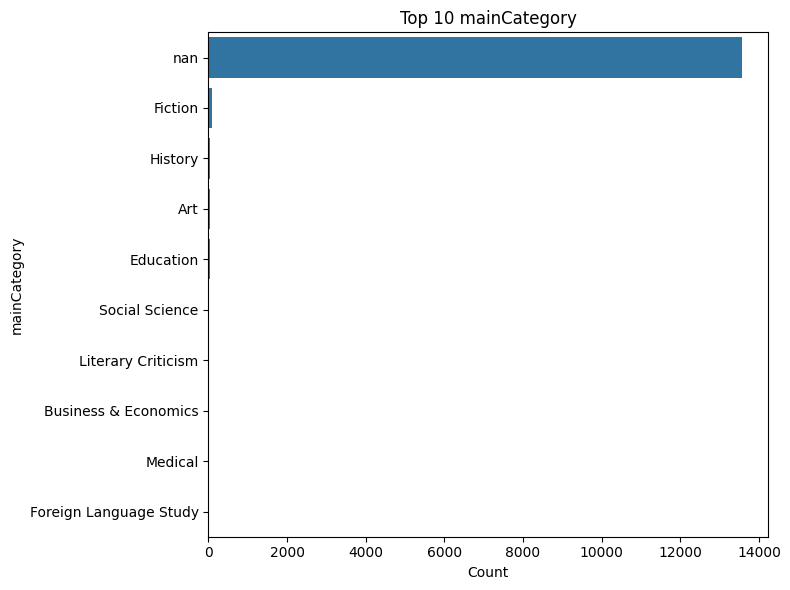

In [34]:
# Checking if the changes worked
# ------------------------------

# List of columns to visualize the top 10 for
columns_to_visualize = ['Author', 'Publisher', 'Subjects', 'mainCategory']

for col in columns_to_visualize:
    if col in merged_items.columns:
        # Get the value counts for the column
        top_values = merged_items[col].value_counts().head(10)

        # Create a figure and axes for the plot
        plt.figure(figsize=(8, 6))

        # Create a bar plot (similar to a histogram for categorical data)
        sns.barplot(x=top_values.values, y=top_values.index)

        plt.title(f'Top 10 {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in merged_items.")

### Replacing all 'nan' occurances with NaN

In [35]:
# Iterate through all columns in the DataFrame
for col in merged_items.columns:
    # Ensure the column is of string type before replacement, which is important as 'nan' is a string we want to replace
    merged_items[col] = merged_items[col].astype(str).replace('nan', np.nan, regex=False)

# Display the first few rows and info to verify
merged_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  15291 non-null  object
 1   Author                 14089 non-null  object
 2   ISBN Valid             14568 non-null  object
 3   Publisher              15266 non-null  object
 4   Subjects               13068 non-null  object
 5   i                      15291 non-null  object
 6   description            2603 non-null   object
 7   mainCategory           1734 non-null   object
 8   publisher              11068 non-null  object
 9   synopsis               7494 non-null   object
 10  language               11282 non-null  object
 11  image                  11294 non-null  object
 12  image_original         11294 non-null  object
 13  title_long             11294 non-null  object
 14  dimensions             10993 non-null  object
 15  dimensions_structur

In [36]:
merged_items['i'] = pd.to_numeric(merged_items['i'], errors='coerce')
merged_items['i'] = merged_items['i'].astype(int)

In [37]:
merged_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15291 entries, 0 to 15290
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title                  15291 non-null  object
 1   Author                 14089 non-null  object
 2   ISBN Valid             14568 non-null  object
 3   Publisher              15266 non-null  object
 4   Subjects               13068 non-null  object
 5   i                      15291 non-null  int64 
 6   description            2603 non-null   object
 7   mainCategory           1734 non-null   object
 8   publisher              11068 non-null  object
 9   synopsis               7494 non-null   object
 10  language               11282 non-null  object
 11  image                  11294 non-null  object
 12  image_original         11294 non-null  object
 13  title_long             11294 non-null  object
 14  dimensions             10993 non-null  object
 15  dimensions_structur

### Final visualization

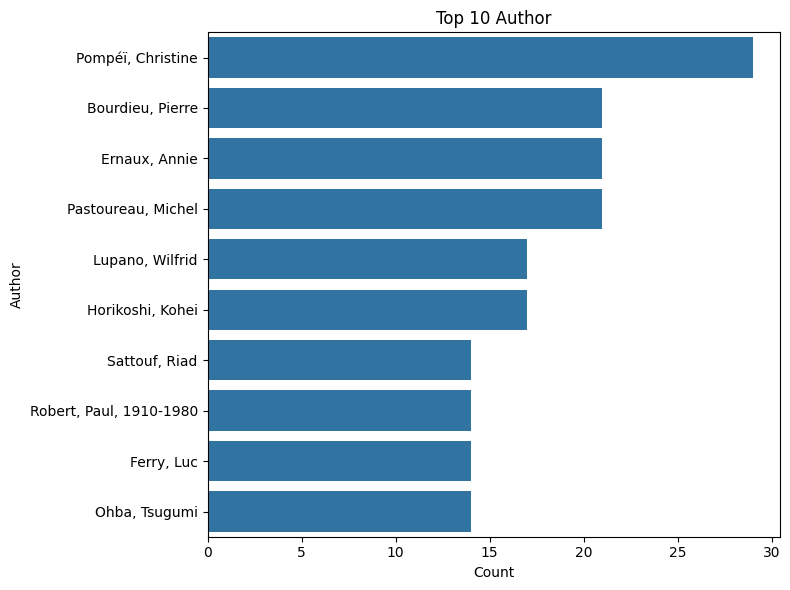

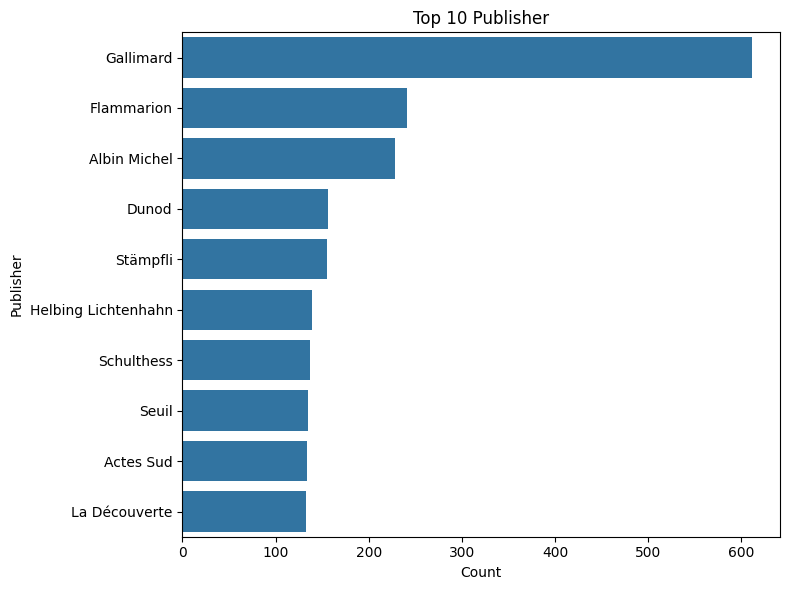

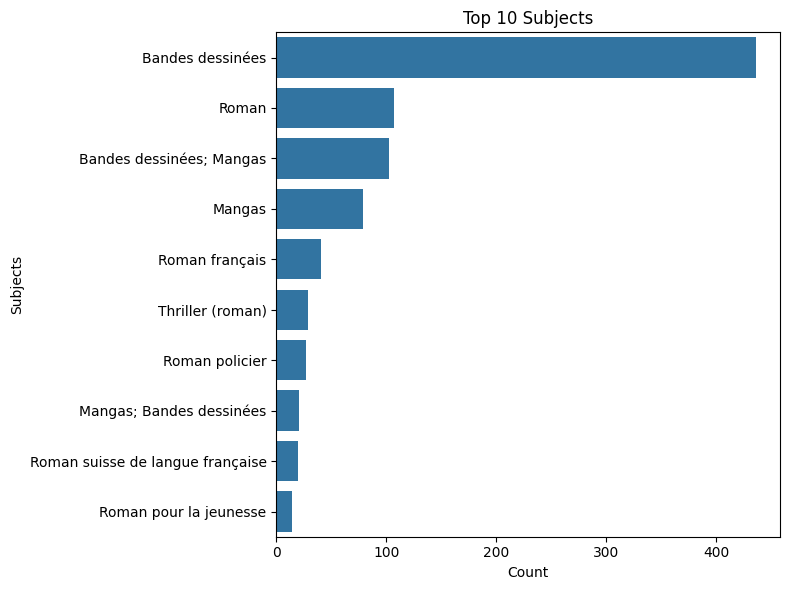

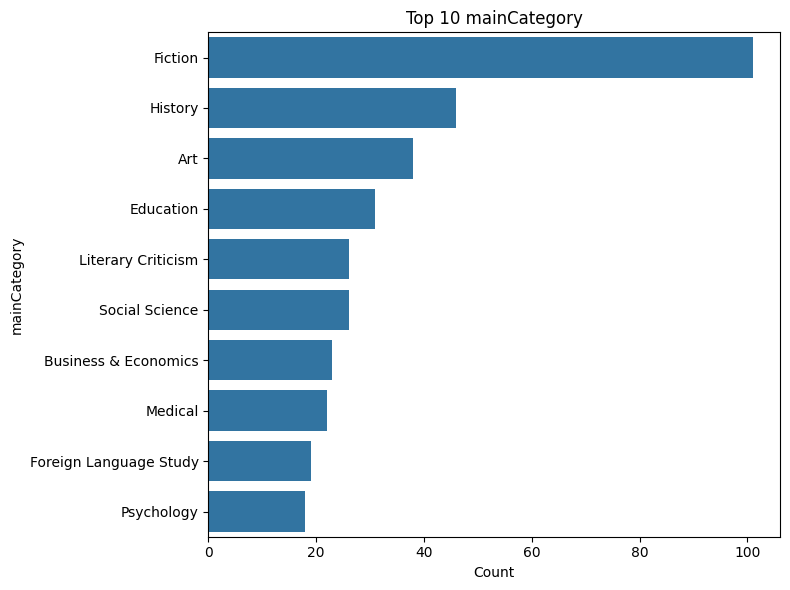

In [38]:
# List of columns to visualize the top 10 for
columns_to_visualize = ['Author', 'Publisher', 'Subjects','mainCategory']

for col in columns_to_visualize:
    if col in merged_items.columns:
        # Get the value counts for the column, automatically dropping np.nan
        top_values = merged_items[col].value_counts().head(10)

        # Check if there are any top values to plot after dropping NaN
        if not top_values.empty:
            # Create a figure and axes for the plot
            plt.figure(figsize=(8, 6))

            # Create a bar plot (similar to a histogram for categorical data)
            sns.barplot(x=top_values.values, y=top_values.index)

            plt.title(f'Top 10 {col}')
            plt.xlabel('Count')
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()
        else:
             print(f"No non-NaN values found to plot for column '{col}'.")
    else:
        print(f"Column '{col}' not found in merged_items.")

## Saving the cleaned merged_items DataFrame

In [39]:
merged_items.to_csv('merged_items.csv', index=False)

## Frequency relating to interactions

### Books with the most interactions

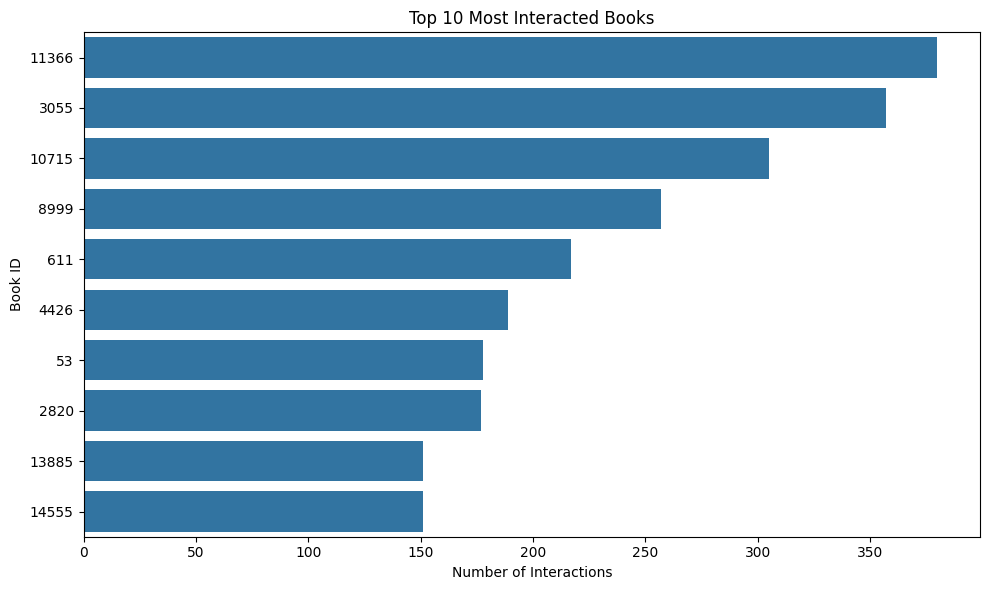

In [187]:
# Get the top 10 interacted books
top_books = interactions['i'].value_counts().head(10).index

# Filter the items DataFrame to get information about the top books
top_books_info = items[items['i'].isin(top_books)]

# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=interactions,
              y='i',
              order=top_books)
plt.title('Top 10 Most Interacted Books')
plt.ylabel('Book ID')
plt.xlabel('Number of Interactions')
plt.tight_layout()
plt.show()

### Number of interactions per user

In [71]:
# Group by user and count the number of interactions
user_interactions_count = interactions.groupby('u')['i'].count().reset_index()

# Rename the count column for clarity
user_interactions_count.rename(columns={'i': 'interaction_count'}, inplace=True)

# Group by interaction count and get the size of each group
interaction_counts_table = user_interactions_count.groupby('interaction_count').size().reset_index()

# Rename columns for better readability
interaction_counts_table.columns = ['Number of Books Interacted With', 'Number of Users']

# Display the table
print("Number of users who interacted with a specific number of books:")
display(interaction_counts_table)

Number of users who interacted with a specific number of books:


,Number of Books Interacted With,Number of Users
0,3,2445
1,4,752
2,5,540
3,6,480
4,7,685
...,...,...
126,175,1
127,199,1
128,200,1
129,254,1


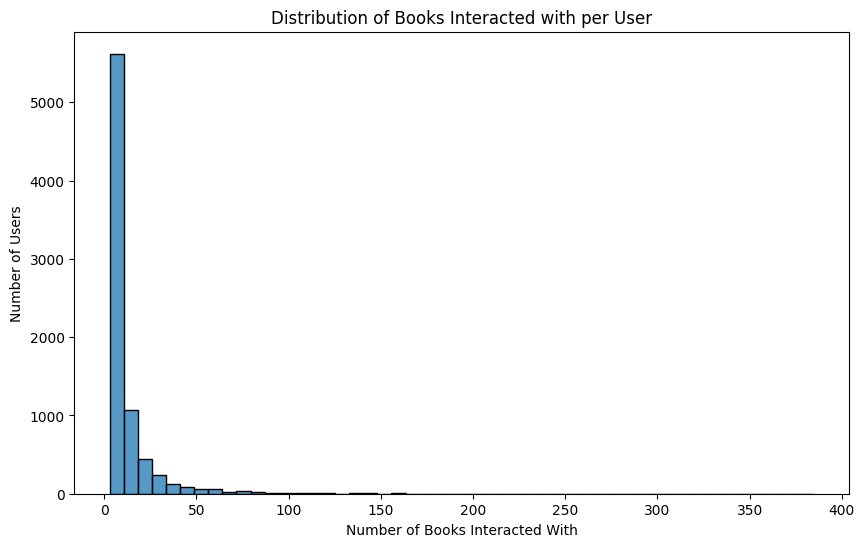

In [188]:
# Plot a histogram showing the distribution of number of interactions per user
plt.figure(figsize=(10, 6))
sns.histplot(user_interactions_count['interaction_count'], bins=50)
plt.title('Distribution of Books Interacted with per User')
plt.xlabel('Number of Books Interacted With')
plt.ylabel('Number of Users')
plt.show()

# OpenAI Embeddings

## Preparing the text for the embeddings

In [66]:
# Creating a column for the combined data we want to use for the embeddings
merged_items["combined_text_openai"] = merged_items.drop(columns=['i','image_original','image','ISBN Valid','title_long','isbn13','isbn','isbn10','msrp','dewey_decimal','dimensions_structured','publisher']).fillna('').astype(str).apply(' '.join, axis=1)

In [67]:
# Creating a new DataFrame with the book IDs and the text for the embeddings
embeddings_text = merged_items[['i','combined_text_openai']]

In [75]:
#openai.api_key = "sk-

In [77]:
texts = embeddings_text["combined_text_openai"].fillna("").tolist()

In [78]:
book_ids = embeddings_text["i"].tolist()

## Getting the embeddings using OpenAI

In [79]:
def get_openai_embeddings(texts, model="text-embedding-3-small", batch_size=100, sleep=1.0):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        try:
            response = openai.embeddings.create(input=batch, model=model)
            batch_embeddings = [r.embedding for r in response.data]
            embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"❌ Error at batch {i}: {e}")
            embeddings.extend([[0]*1536 for _ in batch])  # fallback
        time.sleep(sleep)
    return np.array(embeddings)

In [80]:
book_embeddings_openai = get_openai_embeddings(texts)

100%|██████████| 153/153 [04:58<00:00,  1.95s/it]


In [81]:
np.save("book_embeddings_openai.npy", book_embeddings_openai)

In [95]:
# Adding the embeddings to the embeddings_text DataFrame to see it
embeddings_text["embedding"] = list(book_embeddings_openai)
embeddings_text

<ipython-input-95-4c086641a0a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embeddings_text["embedding"] = list(book_embeddings_openai)


,i,combined_text_openai,embedding
0,0,Classification décimale universelle : édition ...,"[0.004905377048999071, 0.021680716425180435, 0..."
1,1,Les interactions dans l'enseignement des langu...,"[-0.015924476087093353, 0.019420675933361053, ..."
2,2,Histoire de vie et recherche biographique : pe...,"[0.017170127481222153, 0.04921164736151695, 0...."
3,3,Ce livre devrait me permettre de résoudre le c...,"[0.014691997319459915, 0.05934261158108711, 0...."
4,4,"Les années glorieuses : roman / Lemaitre, Pier...","[-0.0011622064048424363, 0.031185323372483253,..."
...,...,...,...
15286,15286,"Le vagabond de Tokyo / Fukutani, Takashi, 1952...","[0.013858351856470108, 0.022979987785220146, -..."
15287,15287,God of high school : le match contre les dieux...,"[0.00035318153095431626, 0.01434679701924324, ..."
15288,15288,"Blue Lock / Kaneshiro, Muneyuki Pika Compétiti...","[0.02148553542792797, 0.056205108761787415, -0..."
15289,15289,Red eyes sword : akame ga kill ! Zero / Takahi...,"[0.03709163889288902, 0.08017517626285553, 0.0..."


# Final preparation of the data before building the models

## Splitting data for train-test

In [25]:
# Sorting the interactions by user and time stamp
interactions = interactions.sort_values(["u", "t"])
interactions.head(10)

,u,i,t
21035,0,0,1.680191e+09
28842,0,1,1.680783e+09
3958,0,2,1.680801e+09
29592,0,3,1.683715e+09
6371,0,3,1.683715e+09
41220,0,4,1.686569e+09
12217,0,5,1.687014e+09
19703,0,6,1.687014e+09
64522,0,7,1.687014e+09
29380,0,8,1.687260e+09


In [26]:
# Adding a percentage rank (for each user)
interactions["pct_rank"] = interactions.groupby("u")["t"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

,u,i,t,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [27]:
# Splitting 80-20 train-test -> based on timestamp
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]

In [28]:
print("Training set size:", train_data.shape[0])
print("Testing set size:", test_data.shape[0])

Training set size: 65417
Testing set size: 21628


In [29]:
print('number of users =', n_users, '| number of books =', n_items) #total number of books, more than in interactions

number of users = 7838 | number of books = 15291


## Preparing mappings

In [30]:
user_ids = interactions["u"].unique()
item_ids = items["i"].unique()
user_id_map = {u: idx for idx, u in enumerate(user_ids)}
item_id_map = {i: idx for idx, i in enumerate(item_ids)}
rev_user_id_map = {v: k for k, v in user_id_map.items()}

n_users = len(user_id_map)
n_items = len(item_id_map)

## Creating matricies

In [31]:
def create_data_matrix(data, n_users, n_items):
    matrix = np.zeros((n_users, n_items), dtype=np.float32)
    for row in data.itertuples():
        if row.u in user_id_map and row.i in item_id_map:
            matrix[user_id_map[row.u], item_id_map[row.i]] = 1
    return matrix

In [87]:
train_matrix = create_data_matrix(train_data, n_users, n_items)
test_matrix = create_data_matrix(test_data, n_users, n_items)

In [ ]:
full_matrix = create_data_matrix(interactions, n_users, n_items)

# Precision and recall function

In [124]:
def precision_recall_at_k(prediction, ground_truth, k=10):
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0
    for user in range(num_users):
        top_k_items = np.argsort(prediction[user])[-k:]
        relevant_items = np.where(ground_truth[user] == 1)[0]
        relevant_items_in_top_k = np.intersect1d(top_k_items, relevant_items).size
        total_relevant = len(relevant_items)
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant if total_relevant > 0 else 0
    return precision_at_k / num_users, recall_at_k / num_users


# OpenAI embeddings model

## Create the user embeddings

In [114]:
# Create index map for embedding rows
embedding_index_map = dict(zip(embeddings_text["i"], range(len(embeddings_text))))

In [115]:
n_users = train_matrix.shape[0]
embedding_dim = book_embeddings_openai.shape[1]
user_embeddings = np.zeros((n_users, embedding_dim), dtype=np.float32)

In [116]:
# Calculating user embeddings by averaging the OpenAI embeddings of the books each user has interacted with
# --------------------------

for u_idx in range(n_users):
    item_indices = np.where(train_matrix[u_idx] > 0)[0]
    valid_embedding_indices = []

    for item_idx in item_indices:
        # Get original item ID
        orig_i = list(item_id_map.keys())[list(item_id_map.values()).index(item_idx)]
        if orig_i in embedding_index_map:
            valid_embedding_indices.append(embedding_index_map[orig_i])

    if valid_embedding_indices:
        vectors = book_embeddings_openai[valid_embedding_indices]
        user_embeddings[u_idx] = vectors.mean(axis=0)

In [117]:
user_embeddings

array([[ 0.00271659,  0.02509907,  0.00921206, ..., -0.00050829,
         0.0010112 , -0.01334028],
       [ 0.02019895,  0.01988657, -0.01847173, ...,  0.00845306,
         0.00187656, -0.0155748 ],
       [ 0.02128974,  0.03198824, -0.01478904, ...,  0.01100291,
         0.00035021, -0.00847189],
       ...,
       [ 0.00884062,  0.04142317, -0.01750297, ...,  0.01771883,
        -0.00168925, -0.0265905 ],
       [ 0.04683898,  0.02917711, -0.03723411, ...,  0.02603676,
         0.00264894, -0.01034922],
       [ 0.01106401,  0.03931578, -0.02577648, ...,  0.00884207,
         0.0055663 ,  0.00194886]], dtype=float32)

In [118]:
# Using cosine similarity to get the similarity between user and book embeddings
content_scores = cosine_similarity(user_embeddings, book_embeddings_openai)

## Aligning user-embeddings with items

In [119]:
# Aligning content-based similarity (embedding) scores with all items
embed_aligned = np.zeros((n_users, n_items), dtype=np.float32)

for orig_i, idx in item_id_map.items():
    if orig_i in embedding_index_map:
        embed_aligned[:, idx] = content_scores[:, embedding_index_map[orig_i]]

In [120]:
embed_aligned

array([[0.6024852 , 0.68398094, 0.5776706 , ..., 0.37793076, 0.34455973,
        0.47436666],
       [0.5543055 , 0.47925365, 0.47502694, ..., 0.43972182, 0.4161337 ,
        0.29969567],
       [0.53133696, 0.44661838, 0.46350938, ..., 0.5383768 , 0.55195177,
        0.31229475],
       ...,
       [0.35212612, 0.23525749, 0.36840886, ..., 0.48395392, 0.439075  ,
        0.16945675],
       [0.37418306, 0.3064214 , 0.29530546, ..., 0.44805235, 0.51081383,
        0.18259425],
       [0.3892966 , 0.29112548, 0.28548482, ..., 0.43342537, 0.45902655,
        0.25804535]], dtype=float32)

## Precision and recall

In [125]:
precision, recall = precision_recall_at_k(embed_aligned, test_matrix, k=10)
print(f"✅ OpenAI Embeddings → Precision@10: {precision:.4f} | Recall@10: {recall:.4f}")

✅ OpenAI Embeddings → Precision@10: 0.0437 | Recall@10: 0.2603


# TF-IDF

# User-user

In [122]:
user_similarity = cosine_similarity(train_matrix)
user_user_scores = user_similarity.dot(train_matrix)

In [ ]:
precision_user, recall_user = precision_recall_at_k(user_user_scores, test_matrix, k=10)
print(f"User-User    → P@10: {precision_user:.4f}, R@10: {recall_user:.4f}")

# Item-item

In [123]:
item_similarity = cosine_similarity(train_matrix.T)
item_item_scores = train_matrix.dot(item_similarity)

In [ ]:
precision_item, recall_item = precision_recall_at_k(item_item_scores, test_matrix, k=10)
print(f"Item-Item    → P@10: {precision_item:.4f}, R@10: {recall_item:.4f}")

# Hybrid

In [84]:
hybrid_scores = (
    0.12 * user_user_scores +
    0.18 * item_item_scores +
    0.1 * user_tfidf_scores +
    0.6 * embed_aligned
)

In [85]:
hybrid_scores

array([[1.97853526, 2.50785317, 2.24905989, ..., 0.38991856, 0.47673684,
        0.39857661],
       [0.3490389 , 0.38701795, 0.42981993, ..., 0.35449146, 0.38200078,
        0.22284588],
       [0.47223203, 0.7803165 , 0.91643989, ..., 0.7847797 , 1.06090921,
        0.40893797],
       ...,
       [0.26261569, 0.21229349, 0.26351615, ..., 0.30661547, 0.31177041,
        0.14195347],
       [0.23374834, 0.20539805, 0.19508915, ..., 0.28102673, 0.33026436,
        0.11321679],
       [0.23497344, 0.20716311, 0.21266235, ..., 0.26155294, 0.27942311,
        0.18043164]])

In [86]:
# --- 10. Generate submission (top-10 recommendations per user) ---
submission = []
for u_idx in range(n_users):
    top_items = np.argsort(hybrid_scores[u_idx])[-10:][::-1]
    top_item_ids = [item_ids[i] for i in top_items]
    submission.append({
        "user_id": rev_user_id_map[u_idx],
        "recommendation": " ".join(map(str, top_item_ids))
    })

submission_df = pd.DataFrame(submission)
print(submission_df)

      user_id                                     recommendation
0           0                        14 11 15 18 1 22 20 12 24 2
1           1                      35 31 29 38 33 36 30 39 37 34
2           2                      80 94 76 54 92 81 84 50 59 60
3           3            123 157 132 166 172 168 130 140 161 151
4           4            192 200 204 194 203 199 195 196 193 206
...       ...                                                ...
7833     7833   7760 7322 975 7306 10460 184 925 11814 5394 8498
7834     7834  1367 7128 13891 15276 13952 8999 11184 7159 10...
7835     7835  3055 6791 4820 9719 4988 4815 8367 4878 6317 1...
7836     7836  3471 14550 6998 14619 3816 14081 15184 14557 1...
7837     7837      88 2191 2209 5642 2198 8284 3288 4898 63 6561

[7838 rows x 2 columns]


In [81]:
# --- 10. Generate submission (top-10 recommendations per user) ---
submission = []
for u_idx in range(n_users):
    top_items = np.argsort(hybrid_scores[u_idx])[-10:][::-1]
    top_item_ids = [item_ids[i] for i in top_items]
    submission.append({
        "user_id": rev_user_id_map[u_idx],
        "recommendation": " ".join(map(str, top_item_ids))
    })

submission_df = pd.DataFrame(submission)
print(submission_df)

      user_id                                     recommendation
0           0                        14 11 15 1 22 12 18 24 20 0
1           1                      35 31 29 30 38 37 36 33 32 39
2           2                      80 94 76 92 77 60 50 54 57 86
3           3            123 157 132 168 172 166 130 140 129 151
4           4            192 200 204 194 199 203 201 206 193 195
...       ...                                                ...
7833     7833   7760 7322 975 7306 7312 5838 5394 184 10460 8498
7834     7834  1367 7128 13891 15276 13952 8999 7159 11184 21...
7835     7835  3055 6791 4820 9719 4988 4815 4878 6199 6317 8367
7836     7836  3471 14550 6998 3816 14619 15184 14081 14557 1...
7837     7837      88 2191 2209 5642 8284 3288 2198 6561 63 5829

[7838 rows x 2 columns]


In [ ]:
# --- 10. Generate submission (top-10 recommendations per user) ---
submission = []
for u_idx in range(n_users):
    top_items = np.argsort(hybrid_scores[u_idx])[-10:][::-1]
    top_item_ids = [item_ids[i] for i in top_items]
    submission.append({
        "user_id": rev_user_id_map[u_idx],
        "recommendation": " ".join(map(str, top_item_ids))
    })

submission_df = pd.DataFrame(submission)
print(submission_df)

      user_id                                     recommendation
0           0                         14 13 15 2 12 11 21 1 17 7
1           1                      31 38 36 37 30 39 29 33 34 35
2           2                      92 53 80 76 58 78 54 81 94 46
3           3            132 161 140 162 144 145 149 172 169 170
4           4            192 195 203 205 202 204 191 197 199 198
...       ...                                                ...
7833     7833  7760 975 7322 7306 10460 11094 4921 8086 2987 798
7834     7834  1367 7128 15276 13891 8999 11184 13890 840 302...
7835     7835  3055 6791 4820 9719 14604 4878 10409 7123 4721...
7836     7836  3471 14550 6998 14557 15065 3816 6746 14552 10...
7837     7837   88 2191 2209 8872 2198 5642 11676 9907 7551 9897

[7838 rows x 2 columns]


In [87]:
submission_df.to_csv("submission_May_18_652_3247.csv", index=False)